## Plant image classification

**Objective** : This notebook's main focus will be on how to use CNN and Keras to classify images of an ornamental plant. We want to know the following things in particular.

- How accurately does CNN classify images?
- Which the best model/architecture for the classification?

## Import Libraries

1. Library **matplotlib, seaborn** required for image visualization.
2. Library **tensorflow,keras** required for modelling and load the images.

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import matplotlib
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay


from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from efficientnet.tfkeras import EfficientNetB3
from tensorflow.keras.applications.inception_v3 import InceptionV3

## Load Data

In [2]:
trainPath = 'Dataset/train'
valPath = 'Dataset/val'
testPath = 'Dataset/test'

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=0.45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

#Train
train_generator = train_datagen.flow_from_directory(
                                            trainPath,
                                                    target_size=(300, 300),
                                                    batch_size=64,
                                                    shuffle=True,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                            )

#Validation
validation_generator=val_datagen.flow_from_directory(
                                            valPath,
                                                    target_size=(300,300),
                                                    batch_size=64,
                                                    shuffle=True,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                )

#Test
test_generator=val_datagen.flow_from_directory(
                                            testPath,
                                                    target_size=(300,300),
                                                    batch_size=64,
                                                    shuffle=True,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                )

Found 1333 images belonging to 8 classes.
Found 294 images belonging to 8 classes.
Found 310 images belonging to 8 classes.


## EDA

**Explore Dataset**

In [4]:
print("Train Num      : ", train_generator.samples)
print("Test Num       : ", test_generator.samples)
print("Validation Num : ", validation_generator.samples)

Train Num      :  1333
Test Num       :  310
Validation Num :  294


In [5]:
# class names
class_names = os.listdir(trainPath)
print('All category : ',class_names)

All category :  ['Agglonema', 'Alocasia', 'Gelombang Cinta', 'Janda Bolong', 'Lidah Mertua', 'Lili Paris', 'Pucuk Merah', 'Suplir']


In [48]:
def countImage(path):
    count  = []
    for x in os.listdir(path):
        count.append(len(os.listdir(path + x)))
    return count


trainCount = countImage('Dataset/train/')
testCount = countImage('Dataset/test/')
valCount = countImage('Dataset/val/')

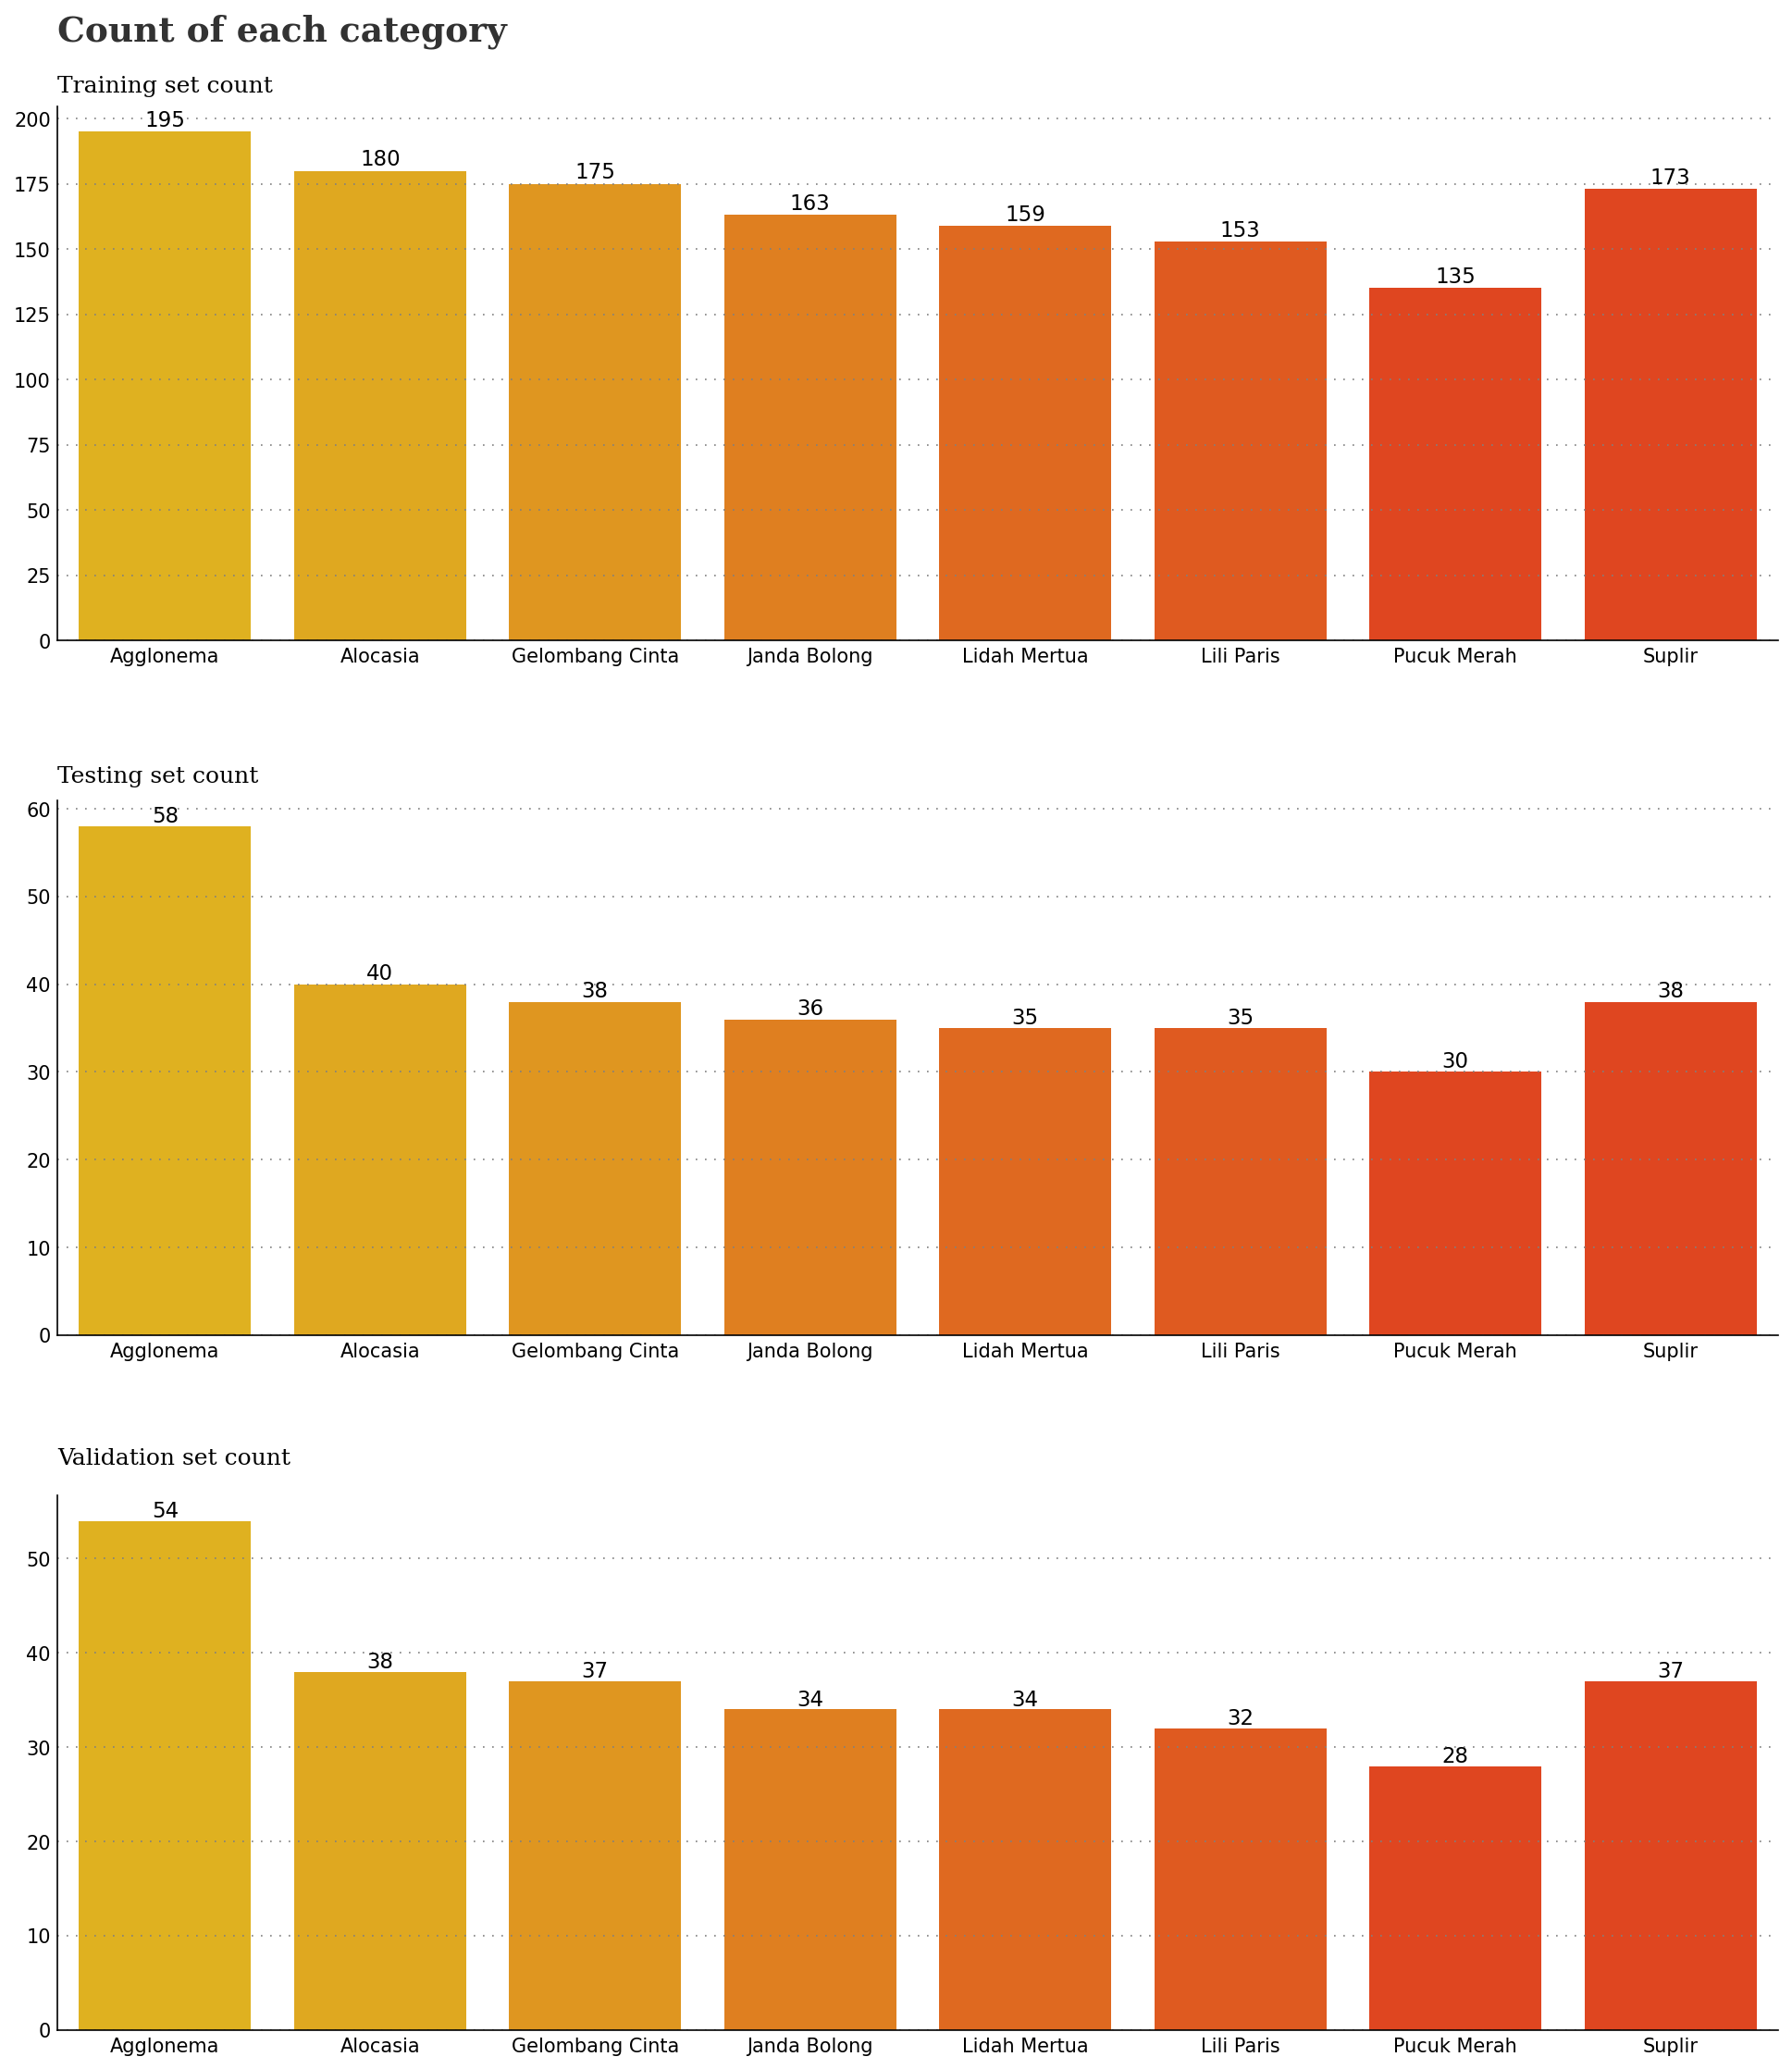

In [88]:
custom_palette = ['#ffc100','#ffb600','#ff9e00','#ff7f00','#ff6100','#ff4d00','#ff3300','#ff3300']
sns.set_palette(custom_palette)


fig = plt.figure(figsize=(16, 18), dpi=150)

gs = fig.add_gridspec(3, 1)
gs.update(wspace=0.4, hspace=0.3)

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[2, 0])

#AX0 - Data Train
ax0.text(-0.5, 230, 'Count of each category', fontsize=18,
         fontweight='bold', fontfamily='serif', color="#323232")
ax0.text(-0.5, 210, 'Training set count',
         fontfamily='serif', fontsize=12, fontweight='light')
sns.barplot(x=class_names,y=trainCount, ax=ax0)
for i in range(8):
    ax0.annotate(f'{trainCount[i]}', 
                    xy =(i, trainCount[i]+2),
                    color='black',
                    horizontalalignment='center',
                    fontsize=11,
                    fontweight='light'
                    )

#AX1 - Data Test
ax1.text(-0.5, 63, 'Testing set count',
         fontfamily='serif', fontsize=12, fontweight='light')
sns.barplot(x=class_names,y=testCount, ax=ax1)
for i in range(8):
    ax1.annotate(f'{testCount[i]}', 
                    xy =(i, testCount[i]+0.5),
                    color='black',
                    horizontalalignment='center',
                    fontsize=11,
                    fontweight='light'
                    )



ax2.text(-0.5, 60, 'Validation set count',
         fontfamily='serif', fontsize=12, fontweight='light')
sns.barplot(x=class_names,y=valCount, ax=ax2)
for i in range(8):
    ax2.annotate(f'{valCount[i]}', 
                    xy =(i, valCount[i]+0.4),
                    color='black',
                    horizontalalignment='center',
                    fontsize=11,
                    fontweight='light'
                    )

for s in ["top", "right"]:
    for i in range(0, 3):
        locals()["ax"+str(i)].spines[s].set_visible(False)

for i in range(0, 3):
    locals()["ax"+str(i)].tick_params(axis=u'both', which=u'both', length=0)
    locals()["ax"+str(i)].grid(color='gray', linestyle=':',
                               axis='y', zorder=0,  dashes=(1, 5))

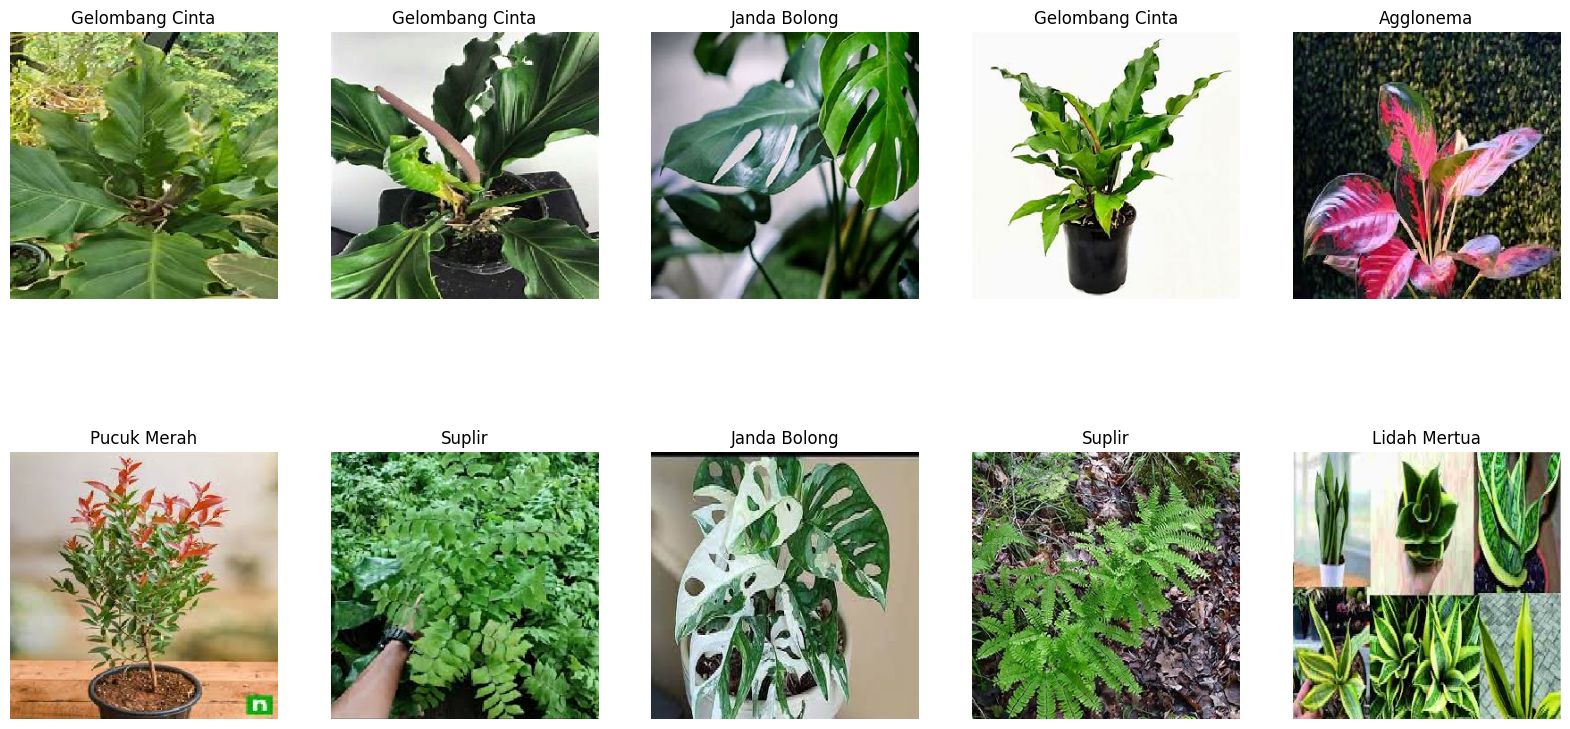

In [6]:
image ,label = next(iter(test_generator))

plt.figure(figsize=(20,10))
for i in range(10) :
  plt.subplot(2,5,i+1)
  plt.imshow(image[i])
  plt.title(class_names[np.argmax(label[i])])
  plt.axis("off")

## Modelling

**Callbacks**

In [3]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss',  
                                    factor=0.4, patience=3, 
                                    verbose=1, mode='min', 
                                    min_delta=0.0001, min_lr=0,
                                    restore_best_weights=True)

### EfficientNet

#### EfficientNetB3

In [8]:
pre_trained_model = EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_shape=(300, 300, 3),
    pooling='avg',
)

In [9]:
for layer in pre_trained_model.layers:
    layer.trainable = False


last_layer = pre_trained_model.get_layer('avg_pool')
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu')(x) # change the activation to relu
x = layers.Dense(1024, activation='relu')(x) #
# change the dropout from 0.2 to 0.3
x = layers.Dropout(0.3)(x)                  
x = layers.Dense(8, activation='softmax')(x)           

model_B3 = Model( pre_trained_model.input,x) 

model_B3.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [11]:
history_b3 = model_B3.fit(
            train_generator,
            validation_data = validation_generator,
            epochs = 15,
            verbose = 1,
            callbacks=[reduceLROnPlat])

Epoch 1/15
21/21 [==============================] - 270s 13s/step - loss: 0.4755 - accuracy: 0.8485 - val_loss: 0.3898 - val_accuracy: 0.8639 - lr: 0.0010
Epoch 2/15
21/21 [==============================] - 263s 13s/step - loss: 0.2973 - accuracy: 0.9002 - val_loss: 0.3778 - val_accuracy: 0.8639 - lr: 0.0010
Epoch 3/15
21/21 [==============================] - 274s 13s/step - loss: 0.2567 - accuracy: 0.9047 - val_loss: 0.3006 - val_accuracy: 0.9014 - lr: 0.0010
Epoch 4/15
21/21 [==============================] - 270s 13s/step - loss: 0.2201 - accuracy: 0.9265 - val_loss: 0.2764 - val_accuracy: 0.9014 - lr: 0.0010
Epoch 5/15
21/21 [==============================] - 270s 13s/step - loss: 0.1837 - accuracy: 0.9407 - val_loss: 0.2414 - val_accuracy: 0.9286 - lr: 0.0010
Epoch 6/15
21/21 [==============================] - 268s 13s/step - loss: 0.1656 - accuracy: 0.9482 - val_loss: 0.2568 - val_accuracy: 0.9082 - lr: 0.0010
Epoch 7/15
21/21 [==============================] - 292s 14s/step - lo

**Saved Model**

In [10]:
#Save model
model_B3.save('Saved_Models/model_EfficientNetB3.h5')

#### EfficientNetB5

In [62]:
from efficientnet.tfkeras import EfficientNetB5

pre_trained_model = EfficientNetB5(
    include_top=False,
    weights="imagenet",
    input_shape=(200, 200, 3),
    pooling='avg',
)

for layer in pre_trained_model.layers:
    layer.trainable = False


last_layer = pre_trained_model.get_layer('avg_pool')
last_output = last_layer.output


x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(1024, activation='relu')(x)              
x = layers.Dense (8, activation='softmax')(x)           

model_B5 = Model(pre_trained_model.input, x) 

model_B5.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [63]:
history_b5 = model_B5.fit(
            train_generator,
            validation_data = validation_generator,
            epochs = 15,
            verbose = 1,
            callbacks=[reduceLROnPlat])

Epoch 1/15
21/21 [==============================] - 195s 9s/step - loss: 1.4802 - accuracy: 0.4629 - val_loss: 0.8646 - val_accuracy: 0.7041 - lr: 0.0010
Epoch 2/15
21/21 [==============================] - 180s 9s/step - loss: 0.7628 - accuracy: 0.7329 - val_loss: 0.6109 - val_accuracy: 0.8061 - lr: 0.0010
Epoch 3/15
21/21 [==============================] - 180s 9s/step - loss: 0.6520 - accuracy: 0.7772 - val_loss: 0.6253 - val_accuracy: 0.8163 - lr: 0.0010
Epoch 4/15
21/21 [==============================] - 180s 9s/step - loss: 0.5468 - accuracy: 0.8027 - val_loss: 0.4773 - val_accuracy: 0.8469 - lr: 0.0010
Epoch 5/15
21/21 [==============================] - 181s 9s/step - loss: 0.4652 - accuracy: 0.8440 - val_loss: 0.4159 - val_accuracy: 0.8810 - lr: 0.0010
Epoch 6/15
21/21 [==============================] - 181s 9s/step - loss: 0.4292 - accuracy: 0.8372 - val_loss: 0.5047 - val_accuracy: 0.8367 - lr: 0.0010
Epoch 7/15
21/21 [==============================] - 180s 9s/step - loss: 0.3

#### EfficientNetB7

In [64]:
from efficientnet.tfkeras import EfficientNetB7

pre_trained_model = EfficientNetB7(
    include_top=False,
    weights="imagenet",
    input_shape=(200, 200, 3),
    pooling='avg',
)

In [65]:
for layer in pre_trained_model.layers:
    layer.trainable = False


last_layer = pre_trained_model.get_layer('avg_pool')
last_output = last_layer.output


x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(1024, activation='relu')(x)              
x = layers.Dense (8, activation='softmax')(x)           

model_B7 = Model( pre_trained_model.input, x) 

model_B7.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [66]:
history = model_B7.fit(
            train_generator,
            validation_data = validation_generator,
            epochs = 20,
            callbacks=[reduceLROnPlat],
            verbose = 1)      

Epoch 1/20
21/21 [==============================] - 335s 15s/step - loss: 1.5378 - accuracy: 0.4396 - val_loss: 0.8354 - val_accuracy: 0.7007 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - 314s 15s/step - loss: 0.9047 - accuracy: 0.7022 - val_loss: 0.6877 - val_accuracy: 0.7789 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - 317s 15s/step - loss: 0.6518 - accuracy: 0.7764 - val_loss: 0.5527 - val_accuracy: 0.8095 - lr: 0.0010
Epoch 4/20
21/21 [==============================] - 315s 15s/step - loss: 0.6056 - accuracy: 0.7914 - val_loss: 0.5432 - val_accuracy: 0.8163 - lr: 0.0010
Epoch 5/20
21/21 [==============================] - 315s 15s/step - loss: 0.5283 - accuracy: 0.8110 - val_loss: 0.5469 - val_accuracy: 0.8299 - lr: 0.0010
Epoch 6/20
21/21 [==============================] - 316s 15s/step - loss: 0.4987 - accuracy: 0.8335 - val_loss: 0.4680 - val_accuracy: 0.8299 - lr: 0.0010
Epoch 7/20
21/21 [==============================] - 316s 15s/step - lo

### Vanilla CNN

In [70]:
model_cnn = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                           input_shape=(200, 200, 3)),  

    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),  
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(8, activation='softmax')  
    ])

model_cnn.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics=['accuracy'])
results = model_cnn.fit(train_generator, epochs=50,batch_size=64,validation_data=validation_generator,verbose=1,callbacks=[reduceLROnPlat])

Epoch 1/50
21/21 [==============================] - 61s 3s/step - loss: 2.0773 - accuracy: 0.1620 - val_loss: 2.0440 - val_accuracy: 0.2483 - lr: 0.0010
Epoch 2/50
21/21 [==============================] - 60s 3s/step - loss: 1.9602 - accuracy: 0.2273 - val_loss: 1.9537 - val_accuracy: 0.2313 - lr: 0.0010
Epoch 3/50
21/21 [==============================] - 62s 3s/step - loss: 1.8712 - accuracy: 0.2656 - val_loss: 1.6812 - val_accuracy: 0.3401 - lr: 0.0010
Epoch 4/50
21/21 [==============================] - 61s 3s/step - loss: 1.7694 - accuracy: 0.3136 - val_loss: 1.6310 - val_accuracy: 0.3367 - lr: 0.0010
Epoch 5/50
21/21 [==============================] - 61s 3s/step - loss: 1.7126 - accuracy: 0.3263 - val_loss: 1.6528 - val_accuracy: 0.3673 - lr: 0.0010
Epoch 6/50
21/21 [==============================] - 54s 3s/step - loss: 1.6664 - accuracy: 0.3383 - val_loss: 1.4791 - val_accuracy: 0.4184 - lr: 0.0010
Epoch 7/50
21/21 [==============================] - 46s 2s/step - loss: 1.6648 - a

### InceptionV3

In [71]:
pre_trained_model = InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(150, 150, 3),
    pooling='avg',
)

In [72]:
for layer in pre_trained_model.layers:
    layer.trainable = False

x = layers.Flatten()(pre_trained_model.output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.3)(x)                
x = layers.Dense (8, activation='softmax')(x)           

model_Inception = Model( pre_trained_model.input, x) 

model_Inception.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [73]:
history = model_Inception.fit(
            train_generator,
            validation_data = validation_generator,
            epochs = 20,
            callbacks=[reduceLROnPlat],
            verbose = 1)      

Epoch 1/20
21/21 [==============================] - 50s 2s/step - loss: 1.5930 - accuracy: 0.4516 - val_loss: 0.8245 - val_accuracy: 0.7347 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - 43s 2s/step - loss: 0.8564 - accuracy: 0.7014 - val_loss: 0.6731 - val_accuracy: 0.7755 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - 43s 2s/step - loss: 0.6205 - accuracy: 0.7869 - val_loss: 0.6063 - val_accuracy: 0.8095 - lr: 0.0010
Epoch 4/20
21/21 [==============================] - 42s 2s/step - loss: 0.5497 - accuracy: 0.8147 - val_loss: 0.5313 - val_accuracy: 0.8061 - lr: 0.0010
Epoch 5/20
21/21 [==============================] - 43s 2s/step - loss: 0.4789 - accuracy: 0.8335 - val_loss: 0.5370 - val_accuracy: 0.8197 - lr: 0.0010
Epoch 6/20
21/21 [==============================] - 43s 2s/step - loss: 0.4754 - accuracy: 0.8380 - val_loss: 0.4435 - val_accuracy: 0.8571 - lr: 0.0010
Epoch 7/20
21/21 [==============================] - 43s 2s/step - loss: 0.3902 - a

In [14]:
#Save model
model  = model_B3.save('Saved_Models/model_EfficientNetB3.h5')

## Evaluate

### Evaluate Test Set

In [91]:
#Get Accuracy of test set for each model

#EfficientNetB3
B3_eval = model_B3.evaluate(test_generator,verbose=0)
B3_acc = round(B3_eval[1],2) * 100

#EfficientNetB5
B5_eval = model_B5.evaluate(test_generator,verbose=0)
B5_acc = round(B5_eval[1],2) * 100

#EfficientNetB7
B7_eval = model_B7.evaluate(test_generator,verbose=0)
B7_acc = round(B7_eval[1],2) * 100

#VanillaCNN
model_cnn_eval = model_cnn.evaluate(test_generator,verbose=0)
model_cnn_acc = round(model_cnn_eval[1],2)* 100

#InceptionNet
InceptionV3_eval = model_Inception.evaluate(test_generator,verbose=0)
InceptionV3_acc = round(InceptionV3_eval[1],2) * 100

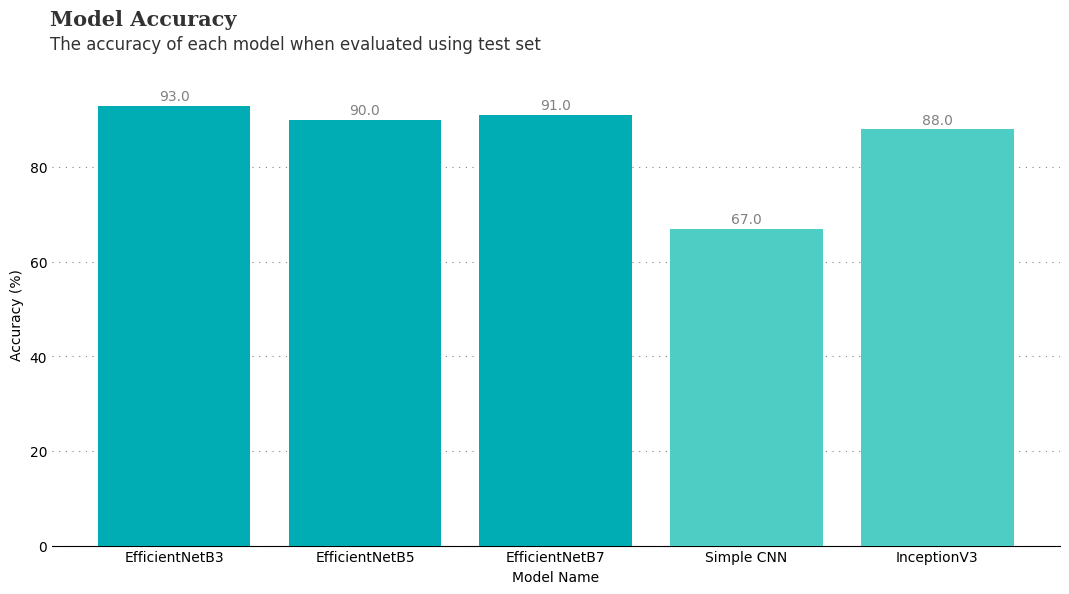

In [119]:
all_acc = [B3_acc,B5_acc,B7_acc,model_cnn_acc,InceptionV3_acc]

fig, ax = plt.subplots(figsize=(13, 6), dpi=100)

x = np.arange(1, len(all_acc)+1)
ax.grid(color='gray', linestyle=':', zorder=0, axis='y',  dashes=(1, 5))
ax.bar(x, height=all_acc, zorder=3,color = ['#00ADB5','#00ADB5','#00ADB5','#4ECDC4','#4ECDC4'])
ax.set_xticks(x)
ax.set_xticklabels(["EfficientNetB3","EfficientNetB5","EfficientNetB7","Simple CNN","InceptionV3"])

ax.set_ylabel('Accuracy (%)')
ax.set_xlabel('Model Name')

ax.text(0.35, 110, 'Model Accuracy', fontsize=15,
        fontweight='bold', fontfamily='serif', color="#323232")
ax.text(0.35, 105, 'The accuracy of each model when evaluated using test set', fontsize=12,
        fontweight='light', color="#323232")


for i, j in enumerate(all_acc):
    ax.annotate(f'{j}', xy=(i+1, j+2), color='gray',
                horizontalalignment='center', verticalalignment='center', fontsize=10)

for spine in ["left", "top", "right"]:
    locals()["ax"].spines[spine].set_visible(False)

locals()["ax"].tick_params(length=0)

Model **EfficinetNetB3** has the highest accuracy

### Learning Plot

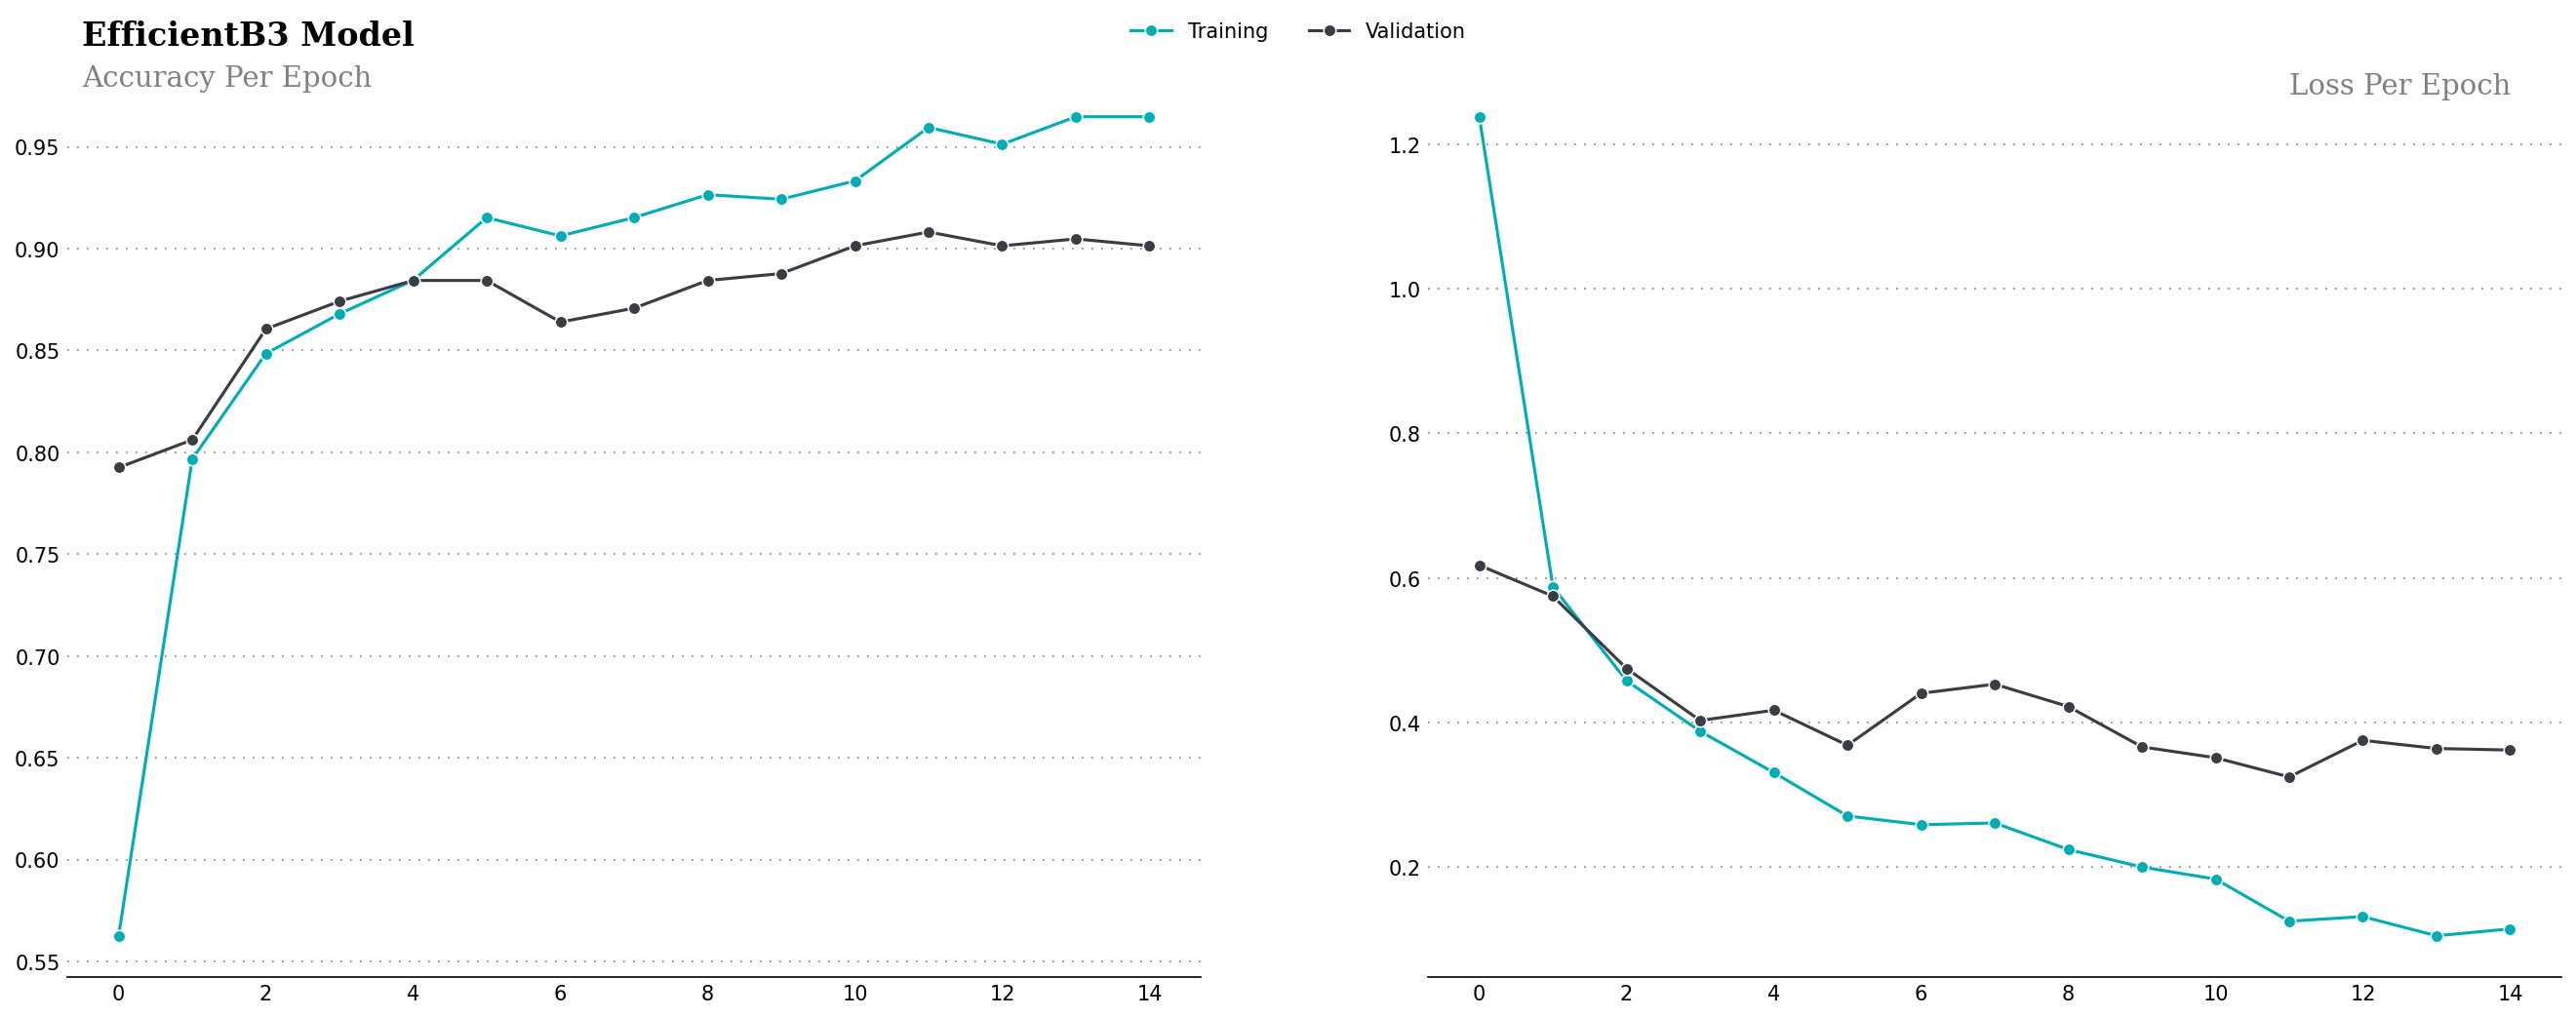

In [122]:
fig = plt.figure(figsize=(22,8), dpi=150)

palette = ['#00ADB5',"#393E46"]

#Acquaire history from EfficientNetB3
len_B3 = len(history_b3.history['accuracy'])
accuracy_B3 = history_b3.history['accuracy']
val_accuracy_B3 = history_b3.history['val_accuracy']

loss_B3 = history_b3.history['loss']
val_loss_B3 = history_b3.history['val_loss']

gs = fig.add_gridspec(1, 2)
gs.update(hspace=0.3)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])

#Lineplot Accuracy
ax0.text(-0.5, 1,"EfficientB3 Model",fontsize=16, fontweight='bold',fontfamily='serif')
ax0.text(-0.5, 0.98,"Accuracy Per Epoch",fontsize=14, fontweight='light',color='gray',fontfamily='serif')
ax0_x_ticks = np.arange(0, len_B3)
ax0.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.lineplot(x=ax0_x_ticks,y=accuracy_B3,ax=ax0,label='Training',color=palette[0],marker='o')
sns.lineplot(x=ax0_x_ticks,y=val_accuracy_B3,ax=ax0,label='Validation',color=palette[1],marker='o')

legend_labels, _= ax0.get_legend_handles_labels()
ax0.legend(legend_labels, ["Training", "Validation"], ncol=2, bbox_to_anchor=(1.25, 1.08), edgecolor='white')

#Lineplot Loss
ax1.text(11, 1.27,"Loss Per Epoch",fontsize=14, fontweight='light',color='gray',fontfamily='serif')
ax1_x_ticks = np.arange(0, len_B3)
ax1.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.lineplot(x=ax0_x_ticks,y=loss_B3,ax=ax1,label='Training',color=palette[0],marker='o')
sns.lineplot(x=ax0_x_ticks,y=val_loss_B3,ax=ax1,label='Validation',color=palette[1],marker='o')
ax1.get_legend().remove()

for s in ["top","right","left"]:
    for i in range(0,2):
        locals()["ax"+str(i)].spines[s].set_visible(False)
        locals()["ax"+str(i)].tick_params(axis=u'both', which=u'both',length=0)

### Confusion Matrix

In [15]:
y_test = []
y_pred = []

for i in range(len(test_generator)) :
    x,y = test_generator.next()
    for j in range(len(y)) :
        y_test.append(class_names[tf.argmax(y[j])])
        y_pred.append(class_names[np.argmax(model_B3.predict(x[j][None,...],verbose=0))])

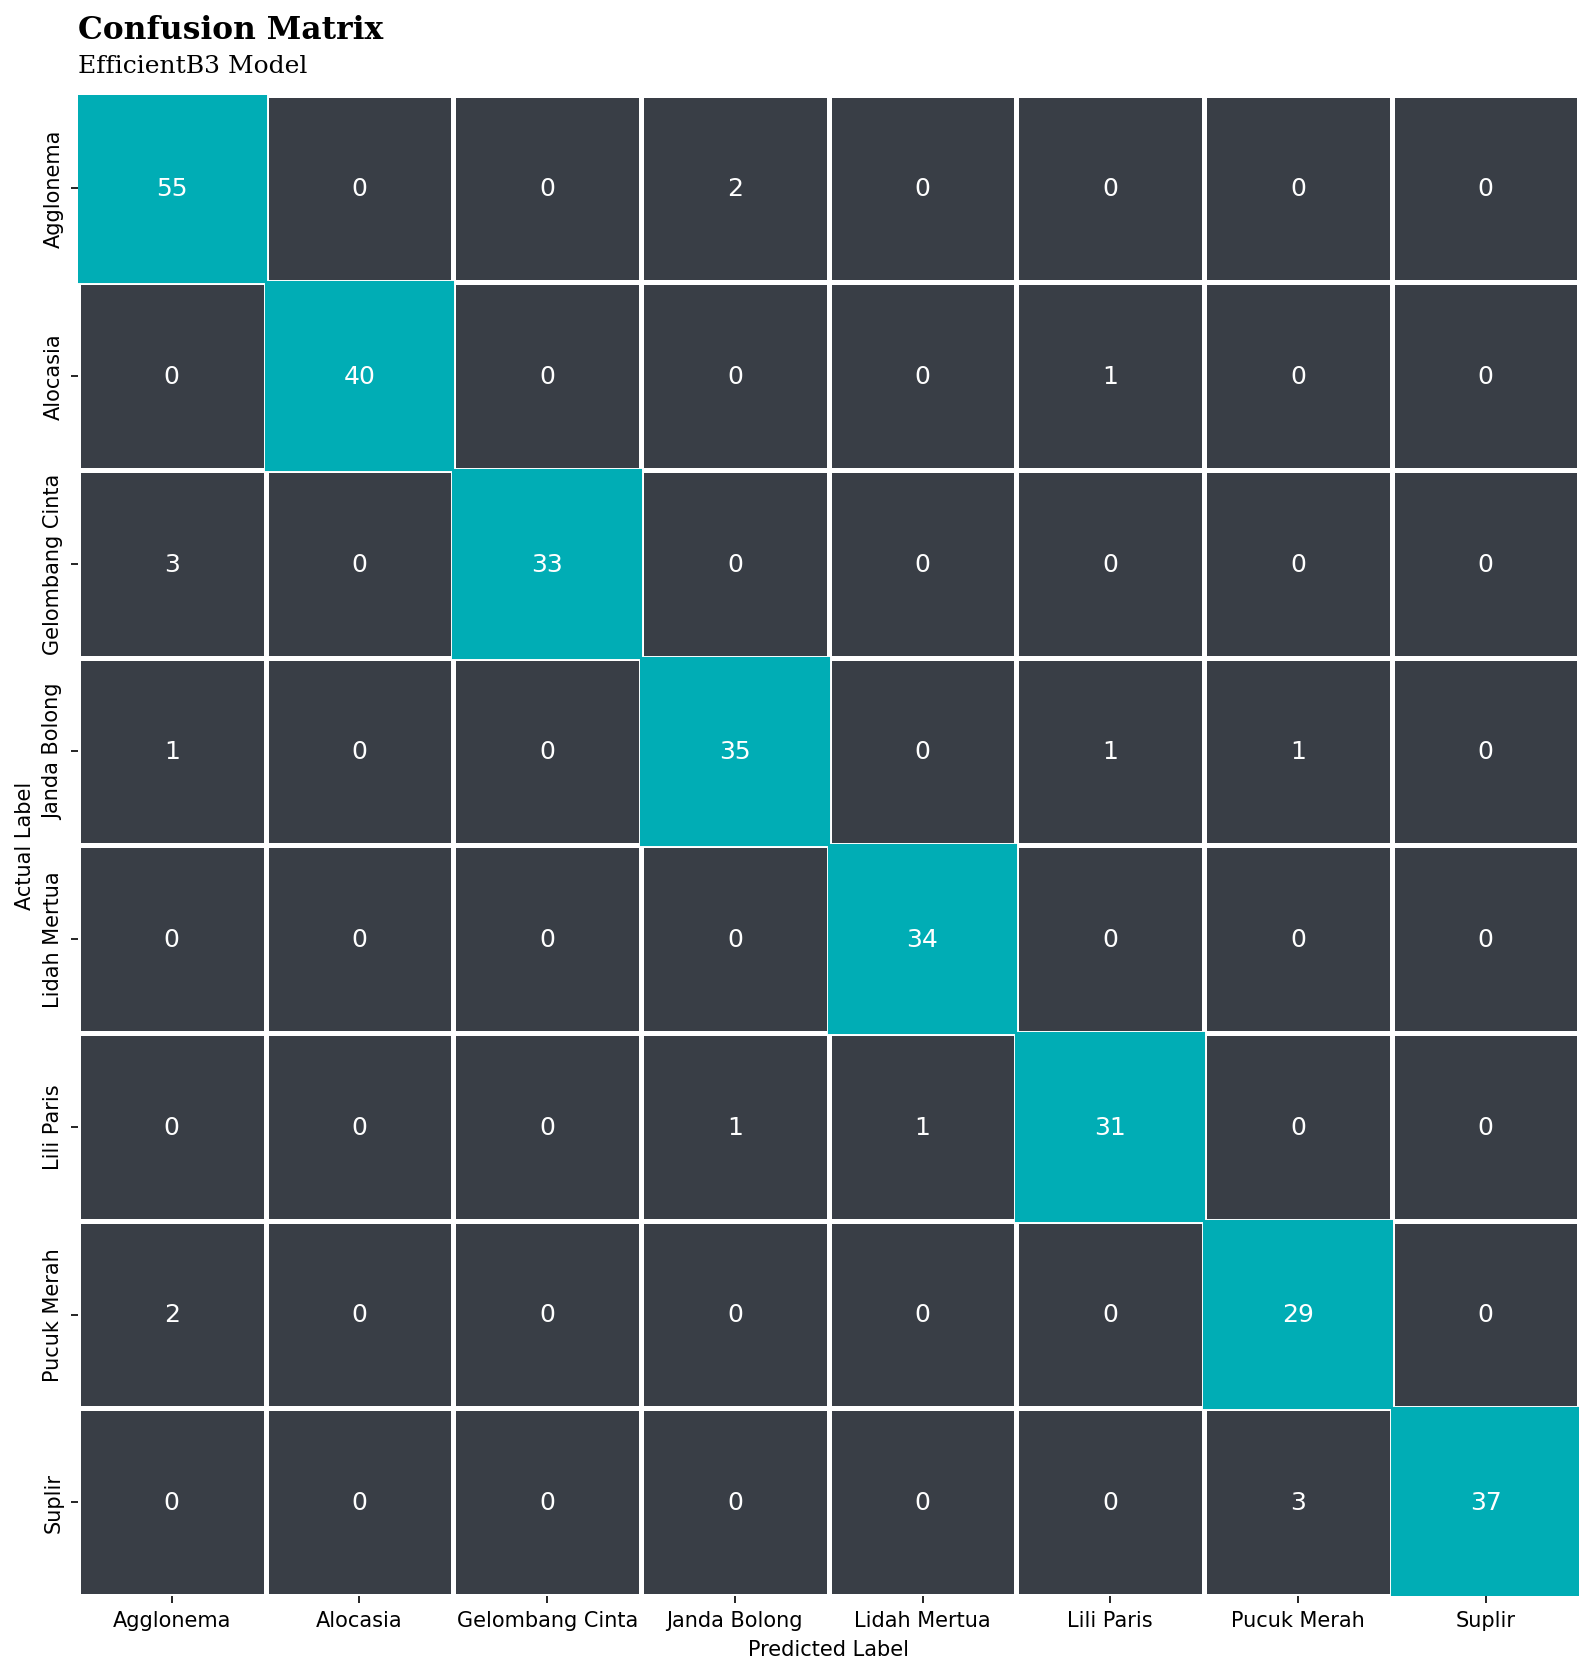

In [16]:
#Confusion Matrix
fig, ax = plt.subplots(figsize=(18, 13),dpi=150)
cm = confusion_matrix(y_test, y_pred)

colors = ["#393E46","#393E46"]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

ax.text(0,-0.3,'Confusion Matrix ',fontfamily='serif',fontsize=15,fontweight='bold')
ax.text(0,-0.12,'EfficientB3 Model',fontfamily='serif',fontsize=12,fontweight='light')
sns.heatmap(ax=ax, data=cm,
            square=True, cbar_kws={"orientation": "horizontal"}, cbar=False,linewidth=1.5, annot=True,cmap=colormap, 
            annot_kws={"fontsize":12},fmt='')

ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)

ax.set_ylabel("Actual Label",fontsize=10)
ax.set_xlabel("Predicted Label",fontsize=10)

from matplotlib.patches import Rectangle
for i in range(0,8):
    ax.add_patch(Rectangle((i, i), 1, 1, fill=True,color='#00ADB5'))

plt.show()

### Preview Prediction Error

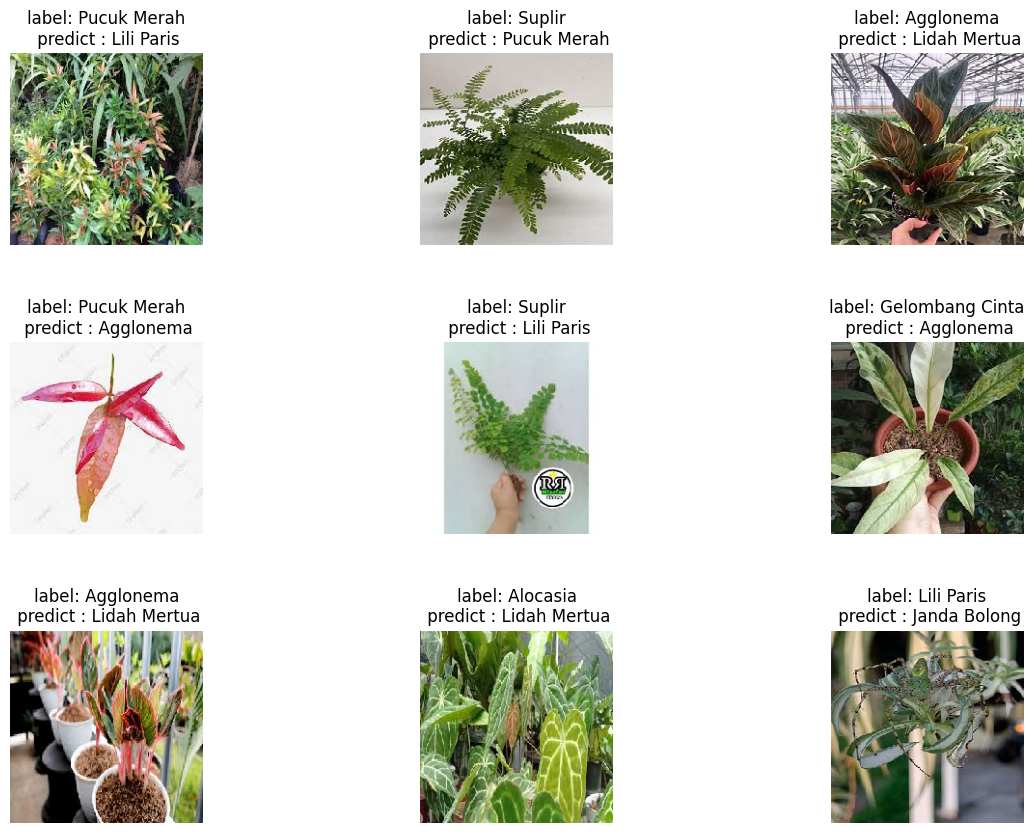

In [132]:
plt.figure(figsize=(15,10))

Truelabel = []
img = []
pred = []

for i in range(len(test_generator)) :
    image,label = test_generator.next()
    for j in range(52):
        if (len(Truelabel) == 9) :
            break

        Aktual = class_names[np.argmax(label[j])]
        y_pred = np.argmax(model_B3.predict(image[j][None,...],verbose=0))
        if (Aktual != class_names[y_pred]):
            Truelabel.append(Aktual)
            img.append(image[j])
            pred.append(y_pred)

for k in range(9) :
    plt.subplot(3,3,k+1)
    plt.subplots_adjust(hspace=0.5)
    plt.imshow(tf.squeeze(img[k]))
    plt.axis('off')
    plt.title(f'label: {Truelabel[k]}\n predict : {class_names[pred[k]]}')

### Predict Image

In [15]:
from keras.models import load_model
import keras.utils as image
import matplotlib.pyplot as plt
import numpy as np

model = load_model('Saved_Models/model_EfficientNetB3.h5',compile=False)
model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

Hasil Prediksi: Alocasia


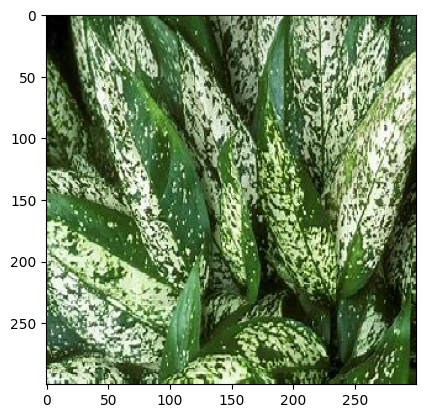

In [18]:
img_path = r"C:\Users\USER\Learning\Bangkit-MachineLearning\main\Dataset\train\Agglonema\Agglonema_0.jpg"
CLASS_NAMES = ['Agglonema', 'Alocasia', 'Gelombang Cinta', 'Janda Bolong', 'Lidah Mertua', 'Lili Paris', 'Pucuk Merah', 'Suplir']

img = image.load_img(img_path, target_size=(300,300))
imgplot = plt.imshow(img)
x = image.img_to_array(img)
x = x/255.0
x = np.expand_dims(x, axis=0)
images = np.vstack([x])

classes = model.predict(images, batch_size=10,verbose=0)
print(f'Hasil Prediksi: {CLASS_NAMES[np.argmax(classes)]}')